# Example Notebook for Keysight  Infiniium Oscilloscopes
This notebook is indendet to give an overview over the functions implemented in the QCoDeS driver for the Keysight Infinium Oscilloscopes. The driver has been tested with the MSOS104A.
Please note that the oscilloscopes have plenty of more functions, that have not yet been implemented. Feel free to contribute, request features or report bugs.

There are two examples in this notebook:
 - Triggered acquisition
 - Averaged acquisition

## General Setup

In [1]:
%matplotlib inline


### Importing Dependencies

In [2]:
#setup
import logging
logger = logging.getLogger()
logger.setLevel(logging.WARNING)
# third party
import matplotlib.pyplot as plt

# qcodes imports
import qcodes as qc
import qcodes.instrument_drivers.Keysight.Infiniium as MSO



### Create the Instrument
please insert the right address of your local scope (TCPIP...) you can find the address with the NI-MAX app or within the network settings of the scope.

In [3]:
mso = MSO.Infiniium('MSO', 'TCPIP0::A-PCSERNO-47466::inst0::INSTR')

Connected to: KEYSIGHT TECHNOLOGIES MSOS104A (serial:MY55510104, firmware:06.00.00901) in 6.89s


c:\users\a-dovoge\qcodes\qcodes\instrument\parameter.py:207: UserWarning: Wrapping get method, original get method will not be directly accessible. It is recommended to define get_raw in your subclass instead.
  warnings.warn('Wrapping get method, original get method will not '


## Example 1: Triggered Acquisition

### Prepare Trace
In this example we are going to acquire the a 100kHz sine wave with 1Vpp from a waveform generator at connected to channel 4 of the scope. Therefore:
 - all the other channels are hidden
 - the time scale is adjusted to allow for one periode
 - the time scale is adjusted to have times starting from zero
 - the range of channel four is set to 1.2V

In [4]:
for i in range(4):
    mso.channels[i].display(False)
mso.ch4.display(True)
mso.timebase_range(1e-5)
mso.timebase_position(5e-6)
mso.ch4.range(1.2)

### Trigger Setup
we want to use the input signal itself as the trigger. Therefor the trigger is first enabled, the trigger source is set and we raise the level to 0.4 V, just for avoiding a boring symmetric function.

In [5]:
mso.trigger_enabled(True)
mso.trigger_edge_source('CHANnel4')
mso.trigger_edge_slope('negative')
mso.ch4.trigger_level(0.4)

### Data Acquisition
We are going to acquire 100k datapoints with 16bit depth over one periode. So we need a sample rate of 10 MS/s.

In [32]:
nPoints = 100000;
mso.acquire_points(nPoints)
mso.acquire_sample_rate(nPoints/mso.timebase_range())
mso.acquire_average(False)

It is important to remember to prepare the trace before acquisition.

In [33]:
mso.ch4.trace.prepare_curvedata()

Then the parameter can be acquire as usual

In [34]:
data = qc.Measure(mso.ch4.trace).run()

DataSet:
   location = 'data/2017-11-22/#005_{name}_16-56-07'
   <Type>   | <array_id>      | <array.name> | <array.shape>
   Measured | MSO_chan4_trace | trace        | (100000,)
acquired at 2017-11-22 16:56:09


The data looks as expected (hopefully)

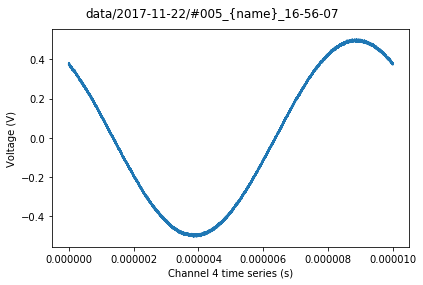

In [35]:
plot = qc.MatPlot(data.arrays['MSO_chan4_trace'])

## Example 2: Averaging & Trigger sweep
This example works without any additional hardware. We simply try to acquire a really good zero trace by averaging over a non-triggred unconnected input.

In [5]:
for i in range(4):
    mso.channels[i].display(False)
mso.ch4.display(True)
trange = 1e-4
mso.timebase_range(trange)
mso.timebase_position(0.5*trange)
mso.ch4.range(1e-5)
mso.ch4.offset(0)

In [6]:
mso.trigger_sweep('auto')

In [7]:
mso.acquire_average(True)

In [8]:
mso.acquire_average_count(1000)

In [ ]:
mso.ch4.trace.prepare_curvedata()
data = qc.Measure(mso.ch4.trace).run()

DEBUG:pyvisa:viWrite(1, b'WAV:POIN?\r\n', 11, 'c_ulong(11)') -> 0
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D52A27AC8>, 20480, 'c_ulong(8)') -> 0
DEBUG:pyvisa:viWrite(1, b':WAVeform:XORigin?\r\n', 20, 'c_ulong(20)') -> 0
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D52A27748>, 20480, 'c_ulong(22)') -> 0
DEBUG:pyvisa:viWrite(1, b':WAVeform:XINCrement?\r\n', 23, 'c_ulong(23)') -> 0
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D52A27AC8>, 20480, 'c_ulong(16)') -> 0
DEBUG:qcodes.loops:Calling .store method of DataSet b

DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D521911C8>, 20480, 'c_ulong(762)') -> 1073676293
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D52191348>, 20480, 'c_ulong(1904)') -> 1073676293
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D521911C8>, 20480, 'c_ulong(8)') -> 1073676293
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D52191348>, 20480, 'c_ulong(2400)') ->

DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D521911C8>, 20480, 'c_ulong(6)') -> 1073676293
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D52191348>, 20480, 'c_ulong(2)') -> 1073676293
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D521911C8>, 20480, 'c_ulong(3302)') -> 1073676293
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D52191348>, 20480, 'c_ulong(8)') -> 1073676293
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 107367

DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D52191348>, 20480, 'c_ulong(20)') -> 1073676293
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D521911C8>, 20480, 'c_ulong(3730)') -> 1073676293
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D52191348>, 20480, 'c_ulong(18)') -> 1073676293
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D521911C8>, 20480, 'c_ulong(8852)') -> 1073676293
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1

DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D521911C8>, 20480, 'c_ulong(664)') -> 1073676293
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D52191348>, 20480, 'c_ulong(20)') -> 1073676293
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D521911C8>, 20480, 'c_ulong(2462)') -> 1073676293
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D52191348>, 20480, 'c_ulong(1554)') -

DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D521911C8>, 20480, 'c_ulong(296)') -> 1073676293
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D52191348>, 20480, 'c_ulong(18)') -> 1073676293
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D521911C8>, 20480, 'c_ulong(502)') -> 1073676293
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D52191348>, 20480, 'c_ulong(4168)') -> 1073676293
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1

DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D52191348>, 20480, 'c_ulong(12)') -> 1073676293
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D521911C8>, 20480, 'c_ulong(5204)') -> 1073676293
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D52191348>, 20480, 'c_ulong(12)') -> 1073676293
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D521911C8>, 20480, 'c_ulong(6040)') ->

DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D52191348>, 20480, 'c_ulong(14)') -> 1073676293
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D521911C8>, 20480, 'c_ulong(2)') -> 1073676293
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D52191348>, 20480, 'c_ulong(3034)') -> 1073676293
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D521911C8>, 20480, 'c_ulong(38)') -> 1073676293
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073

DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D521911C8>, 20480, 'c_ulong(2)') -> 1073676293
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D52191348>, 20480, 'c_ulong(2)') -> 1073676293
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D521911C8>, 20480, 'c_ulong(184)') -> 1073676293
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D52191348>, 20480, 'c_ulong(32)') -> 1073

DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D521911C8>, 20480, 'c_ulong(2)') -> 1073676293
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D52191348>, 20480, 'c_ulong(2)') -> 1073676293
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D521911C8>, 20480, 'c_ulong(2)') -> 1073676293
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D52191348>, 20480, 'c_ulong(8478)') -> 1073

DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D521911C8>, 20480, 'c_ulong(3242)') -> 1073676293
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D52191348>, 20480, 'c_ulong(5568)') -> 1073676293
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D521911C8>, 20480, 'c_ulong(10)') -> 1073676293
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D52191348>, 20480, 'c_ulong(988)') -> 1073676293
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 

DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D52191348>, 20480, 'c_ulong(76)') -> 1073676293
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D521911C8>, 20480, 'c_ulong(2)') -> 1073676293
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D52191348>, 20480, 'c_ulong(714)') -> 1073676293
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D521911C8>, 20480, 'c_ulong(3118)') -> 1

DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D52191348>, 20480, 'c_ulong(2318)') -> 1073676293
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D521911C8>, 20480, 'c_ulong(8)') -> 1073676293
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D52191348>, 20480, 'c_ulong(214)') -> 1073676293
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D521911C8>, 20480, 'c_ulong(2)') -> 1073676293
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073

DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D521911C8>, 20480, 'c_ulong(6)') -> 1073676293
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D52191348>, 20480, 'c_ulong(1202)') -> 1073676293
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D521911C8>, 20480, 'c_ulong(2196)') -> 1073676293
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D52191348>, 20480, 'c_ulong(4362)') -> 1073676293
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 

DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D52191348>, 20480, 'c_ulong(10)') -> 1073676293
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D521911C8>, 20480, 'c_ulong(1988)') -> 1073676293
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D52191348>, 20480, 'c_ulong(8560)') -> 1073676293
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D521911C8>, 20480, 'c_ulong(12)') ->

DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D52191348>, 20480, 'c_ulong(3190)') -> 1073676293
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D521911C8>, 20480, 'c_ulong(2)') -> 1073676293
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D52191348>, 20480, 'c_ulong(4)') -> 1073676293
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D521911C8>, 20480, 'c_ulong(2)') -> 1073676293
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 107367

DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D521911C8>, 20480, 'c_ulong(2)') -> 1073676293
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D52191348>, 20480, 'c_ulong(2)') -> 1073676293
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D521911C8>, 20480, 'c_ulong(3580)') -> 1073676293
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D52191348>, 20480, 'c_ulong(2)') -> 1073

DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D521911C8>, 20480, 'c_ulong(5466)') -> 1073676293
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D52191348>, 20480, 'c_ulong(8)') -> 1073676293
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D521911C8>, 20480, 'c_ulong(2166)') -> 1073676293
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D52191348>, 20480, 'c_ulong(1266)') -> 1073676293
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 

DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D52191348>, 20480, 'c_ulong(2)') -> 1073676293
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D521911C8>, 20480, 'c_ulong(2)') -> 1073676293
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D52191348>, 20480, 'c_ulong(3926)') -> 1073676293
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D521911C8>, 20480, 'c_ulong(5088)') -> 1

DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D52191348>, 20480, 'c_ulong(2)') -> 1073676293
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D521911C8>, 20480, 'c_ulong(2)') -> 1073676293
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D52191348>, 20480, 'c_ulong(2)') -> 1073676293
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D521911C8>, 20480, 'c_ulong(2)') -> 1073676293
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 107367629

DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D521911C8>, 20480, 'c_ulong(182)') -> 1073676293
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D52191348>, 20480, 'c_ulong(14)') -> 1073676293
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D521911C8>, 20480, 'c_ulong(4114)') -> 1073676293
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D52191348>, 20480, 'c_ulong(438)') -> 1073676293
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1

DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D52191348>, 20480, 'c_ulong(22)') -> 1073676293
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D521911C8>, 20480, 'c_ulong(886)') -> 1073676293
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D52191348>, 20480, 'c_ulong(20)') -> 1073676293
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D521911C8>, 20480, 'c_ulong(2)') -> 107

DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D52191348>, 20480, 'c_ulong(2)') -> 1073676293
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D521911C8>, 20480, 'c_ulong(3394)') -> 1073676293
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D52191348>, 20480, 'c_ulong(2)') -> 1073676293
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D521911C8>, 20480, 'c_ulong(694)') -> 1073676293
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073

DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D521911C8>, 20480, 'c_ulong(12)') -> 1073676293
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D52191348>, 20480, 'c_ulong(522)') -> 1073676293
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D521911C8>, 20480, 'c_ulong(2270)') -> 1073676293
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D52191348>, 20480, 'c_ulong(18)') -> 

DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D521911C8>, 20480, 'c_ulong(12)') -> 1073676293
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D52191348>, 20480, 'c_ulong(884)') -> 1073676293
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D521911C8>, 20480, 'c_ulong(1444)') -> 1073676293
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D52191348>, 20480, 'c_ulong(4)') -> 1073676293
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 107

DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D52191348>, 20480, 'c_ulong(3724)') -> 1073676293
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D521911C8>, 20480, 'c_ulong(1890)') -> 1073676293
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D52191348>, 20480, 'c_ulong(8)') -> 1073676293
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D521911C8>, 20480, 'c_ulong(3634)') -

DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D52191348>, 20480, 'c_ulong(5770)') -> 1073676293
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D521911C8>, 20480, 'c_ulong(22)') -> 1073676293
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D52191348>, 20480, 'c_ulong(3454)') -> 1073676293
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D521911C8>, 20480, 'c_ulong(398)') -> 1073676293
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 

DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D52191348>, 20480, 'c_ulong(1584)') -> 1073676293
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D521911C8>, 20480, 'c_ulong(2)') -> 1073676293
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D52191348>, 20480, 'c_ulong(2)') -> 1073676293
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D521911C8>, 20480, 'c_ulong(6992)') -> 1073676293
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 107

DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D52191348>, 20480, 'c_ulong(3012)') -> 1073676293
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D521911C8>, 20480, 'c_ulong(2542)') -> 1073676293
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D52191348>, 20480, 'c_ulong(28)') -> 1073676293
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D521911C8>, 20480, 'c_ulong(7932)') -> 1073676293
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read:

DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D521911C8>, 20480, 'c_ulong(3136)') -> 1073676293
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D52191348>, 20480, 'c_ulong(18)') -> 1073676293
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D521911C8>, 20480, 'c_ulong(2762)') -> 1073676293
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D52191348>, 20480, 'c_ulong(2)') -> 

DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D521911C8>, 20480, 'c_ulong(20)') -> 1073676293
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D52191348>, 20480, 'c_ulong(638)') -> 1073676293
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D521911C8>, 20480, 'c_ulong(4688)') -> 1073676293
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D52191348>, 20480, 'c_ulong(2)') -> 1073676293
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 107

DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D52191348>, 20480, 'c_ulong(2894)') -> 1073676293
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D521911C8>, 20480, 'c_ulong(2734)') -> 1073676293
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D52191348>, 20480, 'c_ulong(3170)') -> 1073676293
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D521911C8>, 20480, 'c_ulong(910)')

DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D52191348>, 20480, 'c_ulong(2056)') -> 1073676293
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D521911C8>, 20480, 'c_ulong(2)') -> 1073676293
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D52191348>, 20480, 'c_ulong(4)') -> 1073676293
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D521911C8>, 20480, 'c_ulong(2)') -> 1073676293
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 107367

DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D521911C8>, 20480, 'c_ulong(6682)') -> 1073676293
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D52191348>, 20480, 'c_ulong(18)') -> 1073676293
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D521911C8>, 20480, 'c_ulong(2124)') -> 1073676293
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D52191348>, 20480, 'c_ulong(12)') ->

DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D521911C8>, 20480, 'c_ulong(14)') -> 1073676293
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D52191348>, 20480, 'c_ulong(610)') -> 1073676293
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D521911C8>, 20480, 'c_ulong(414)') -> 1073676293
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D52191348>, 20480, 'c_ulong(4034)') -> 1073676293
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1

DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D52191348>, 20480, 'c_ulong(5020)') -> 1073676293
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D521911C8>, 20480, 'c_ulong(9644)') -> 1073676293
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D52191348>, 20480, 'c_ulong(10)') -> 1073676293
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D521911C8>, 20480, 'c_ulong(124)') -> 1073676293
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 

DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D521911C8>, 20480, 'c_ulong(1956)') -> 1073676293
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D52191348>, 20480, 'c_ulong(10)') -> 1073676293
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D521911C8>, 20480, 'c_ulong(228)') -> 1073676293
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D52191348>, 20480, 'c_ulong(2)') -> 1

DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D521911C8>, 20480, 'c_ulong(500)') -> 1073676293
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D52191348>, 20480, 'c_ulong(3090)') -> 1073676293
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D521911C8>, 20480, 'c_ulong(2)') -> 1073676293
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D52191348>, 20480, 'c_ulong(2)') -> 1073676293
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073

DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D52191348>, 20480, 'c_ulong(20)') -> 1073676293
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D521911C8>, 20480, 'c_ulong(6358)') -> 1073676293
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D52191348>, 20480, 'c_ulong(2674)') -> 1073676293
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D521911C8>, 20480, 'c_ulong(16)') ->

DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D52191348>, 20480, 'c_ulong(2)') -> 1073676293
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D521911C8>, 20480, 'c_ulong(2)') -> 1073676293
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D52191348>, 20480, 'c_ulong(2)') -> 1073676293
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D521911C8>, 20480, 'c_ulong(2498)') -> 1073676293
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 107367

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to fileDEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.d

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.data.gnuplot_format:Wrote to file
DEBUG:qcodes.

In [ ]:
plot = qc.MatPlot(data.arrays['MSO_chan4_trace'])

In [21]:
1000*mso.acquire_timespan()

10.0

In [14]:
trange = 1e-4


In [16]:
mso.ch4.trace.prepare_curvedata()
mso.ch4.trace()

DEBUG:pyvisa:viWrite(1, b'WAV:POIN?\r\n', 11, 'c_ulong(11)') -> 0
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D52A277C8>, 20480, 'c_ulong(8)') -> 0
DEBUG:pyvisa:viWrite(1, b':WAVeform:XORigin?\r\n', 20, 'c_ulong(20)') -> 0
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D52A276C8>, 20480, 'c_ulong(22)') -> 0
DEBUG:pyvisa:viWrite(1, b':WAVeform:XINCrement?\r\n', 23, 'c_ulong(23)') -> 0
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D52A277C8>, 20480, 'c_ulong(16)') -> 0
DEBUG:pyvisa:viWrite(1, b':RSTate?\r\n', 10, 'c_ulong

DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D52A277C8>, 20480, 'c_ulong(20480)') -> 1073676294
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D52A276C8>, 20480, 'c_ulong(16966)') -> 1073676293
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D52A277C8>, 20480, 'c_ulong(2)') -> 1073676293
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D52A276C8>, 20480, 'c_ulong(2)') ->

DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D52A277C8>, 20480, 'c_ulong(20480)') -> 1073676294
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D52A276C8>, 20480, 'c_ulong(20480)') -> 1073676294
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D52A277C8>, 20480, 'c_ulong(20480)') -> 1073676294
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D52A276C8>, 20480, 'c_ulong(20480)') -> 1073676294
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count

DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D52A276C8>, 20480, 'c_ulong(20480)') -> 1073676294
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D52A277C8>, 20480, 'c_ulong(20480)') -> 1073676294
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D52A276C8>, 20480, 'c_ulong(20480)') -> 1073676294
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D52A277C8>, 20480, 'c_ulong(204

DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D52A276C8>, 20480, 'c_ulong(20480)') -> 1073676294
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D52A277C8>, 20480, 'c_ulong(20480)') -> 1073676294
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D52A276C8>, 20480, 'c_ulong(20480)') -> 1073676294
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D52A277C8>, 20480, 'c_ulong(20480)') -> 1073676294
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count

DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D52A277C8>, 20480, 'c_ulong(2)') -> 1073676293
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D52A276C8>, 20480, 'c_ulong(20480)') -> 1073676294
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D52A277C8>, 20480, 'c_ulong(20480)') -> 1073676294
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D52A276C8>, 20480, 'c_ulong(20480)'

DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D52A277C8>, 20480, 'c_ulong(20480)') -> 1073676294
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D52A276C8>, 20480, 'c_ulong(4080)') -> 0
DEBUG:pyvisa:viWrite(1, b':WAVeform:XORigin?\r\n', 20, 'c_ulong(20)') -> 0
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D52A277C8>, 20480, 'c_ulong(22)') -> 0
DEBUG:pyvisa:viWrite(1, b':WAVeform:XINCrement?\r\n', 23, 'c_ulong(23)') -> 0
DEBUG:pyvisa:TCPIP0::A-PCSERNO-47466::inst0::INSTR - reading 20480 bytes (last status <StatusCode.success_max_count_read: 1073676294>)
DEBUG:pyvisa:viRead(1, <ctypes.c_char_Array_20480 object at 0x0000014D52A276C8>, 20480, 'c_ulong(16)') -

array([  5.59220280e-05,   5.56701260e-05,   5.54182240e-05, ...,
         4.98763800e-05,   5.01282820e-05,   5.06320860e-05])

In [10]:
import time

In [12]:
logging.debug("test")
time.sleep(1)
logging.debug("test")

DEBUG:root:test
DEBUG:root:test


# Example 3: Averaging with trigger

In [62]:
for i in range(4):
    mso.channels[i].display(False)
mso.ch4.display(True)
trange = 1e-2
mso.timebase_range(trange)
mso.timebase_position(0.5*trange)
mso.ch4.range(1.2)
mso.ch4.offset(0)
mso.acquisition_factor = 10

nPoints = 1000000
mso.acquire_points(nPoints)
mso.acquire_sample_rate(nPoints/mso.timebase_range())
mso.acquire_points(nPoints)
mso.acquire_sample_rate(nPoints/mso.timebase_range())
mso.acquire_interpolate(False)

mso.trigger_sweep('triggered')
mso.trigger_enabled(True)
mso.trigger_edge_source('CHANnel3')
mso.trigger_edge_slope('negative')
mso.ch3.trigger_level(1.5)
mso.acquire_average(True)
mso.acquire_average_count(40)

In [63]:
mso.acquire_timespan()*mso.acquire_average_count()

0.4

In [64]:
%%time
mso.ch4.trace.prepare_curvedata()
data = qc.Measure(mso.ch4.trace).run()

DataSet:
   location = 'data/2017-11-22/#027_{name}_18-12-53'
   <Type>   | <array_id>      | <array.name> | <array.shape>
   Measured | MSO_chan4_trace | trace        | (1000000,)
acquired at 2017-11-22 18:13:13
Wall time: 19.9 s


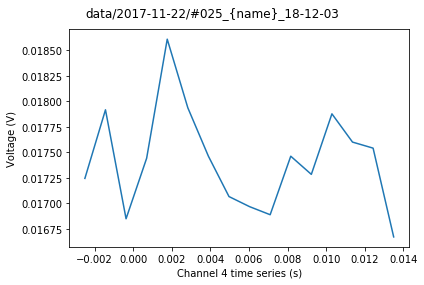

In [52]:
plot = qc.MatPlot(data.arrays['MSO_chan4_trace'])